# ESPnet Speech Translation Demonstration

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/espnet/notebook/blob/master/st_demo.ipynb)

See also

- ESPnet: https://github.com/espnet/espnet
- ESPnet documentation: https://espnet.github.io/espnet/
- TTS demo: https://colab.research.google.com/github/espnet/notebook/blob/master/tts_realtime_demo.ipynb 

Author: [Shigeki Karita](https://github.com/ShigekiKarita)

## Install

It takes around 3 minutes. Please keep waiting for a while.

In [ ]:
# OS setup
!cat /etc/os-release
!apt-get install -qq bc tree sox

# espnet and moses setup
!git clone -q https://github.com/ShigekiKarita/espnet.git
!pip install -q torch==1.1
!cd espnet; git checkout c0466d9a356c1a33f671a546426d7bc33b5b17e8; pip install -q -e .
!cd espnet/tools/; make moses.done

# download pre-compiled warp-ctc and kaldi tools
!espnet/utils/download_from_google_drive.sh \
    "https://drive.google.com/open?id=13Y4tSygc8WtqzvAVGK_vRV9GlV7TRC0w" espnet/tools tar.gz > /dev/null

# make dummy activate
!mkdir -p espnet/tools/venv/bin && touch espnet/tools/venv/bin/activate
!echo "setup done."

NAME="Ubuntu"
VERSION="18.04.3 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.3 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic
Selecting previously unselected package libopencore-amrnb0:amd64.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../0-libopencore-amrnb0_0.1.3-2.1_amd64.deb ...
Unpacking libopencore-amrnb0:amd64 (0.1.3-2.1) ...
Selecting previously unselected package libopencore-amrwb0:amd64.
Preparing to unpack .../1-libopencore-amrwb0_0.1.3-2.1_amd64.deb ...
Unpacking libopencore-amrwb0:amd64 (0.1.3-2.1) ...
Selecting previously unselected package libmagic-mgc.
Preparing to unpack .../2-libmagic-mgc_1%3a5.32-2ubuntu0.3_amd64.deb ...
Unpacking libmagic-mgc (1:5.32-2ubuntu0.3)



---
## Spanish speech -> English text translation

This audio says "yo soy José."

In [ ]:
from IPython.display import display, Audio
display(Audio("/content/espnet/test_utils/st_test.wav", rate=16000))

Let's translate this into English text by our pretrained Transformer ST model trained on the Fisher-CALLHOME Spanish dataset.

In [ ]:
# move on the recipe directory
import os
os.chdir("/content/espnet/egs/fisher_callhome_spanish/st1")

!../../../utils/translate_wav.sh --models fisher_callhome_spanish.transformer.v1.es-en ../../../test_utils/st_test.wav | tee /content/translated.txt

--2020-02-01 06:27:27--  https://drive.google.com/uc?export=download&id=1hawp5ZLw4_SIHIT3edglxbKIIkPVe8n3
Resolving drive.google.com (drive.google.com)... 108.177.112.101, 108.177.112.138, 108.177.112.113, ...
Connecting to drive.google.com (drive.google.com)|108.177.112.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: 'decode/download/fisher_callhome_spanish.transformer.v1.es-en/ggCWsF..tar.gz'

decode/download/fis     [ <=>                ]   3.26K  --.-KB/s    in 0s      

2020-02-01 06:27:27 (71.2 MB/s) - 'decode/download/fisher_callhome_spanish.transformer.v1.es-en/ggCWsF..tar.gz' saved [3338]


gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3338    0  3338    0     0  16944      0 --:--:-- --:--:-- --

As seen above, we successfully obtained the result: **"Translated text: yes i'm jose"**!

## English translated text-to-speech synthesis

Now let's generate an **English speech** from the translated text using a pretrained ESPnet-TTS model.

In [ ]:
!sed -n 's/Translated text://p'  /content/translated.txt | tr '[:lower:]' '[:upper:]' | tee /content/translated_sed.txt
!../../../utils/synth_wav.sh /content/translated_sed.txt

 YES I'M JOSE
stage 0: Data preparation
/content/espnet/egs/ljspeech/tts1/../../../utils/data2json.sh --trans_type char decode/translated_sed/data decode/download/ljspeech.transformer.v1/data/lang_1char/train_no_dev_units.txt
stage 2: Decoding
stage 3: Synthesis with Griffin-Lim
apply-cmvn --norm-vars=true --reverse=true decode/download/ljspeech.transformer.v1/data/train_no_dev/cmvn.ark scp:decode/translated_sed/outputs/feats.scp ark,scp:decode/translated_sed/outputs_denorm/feats.ark,decode/translated_sed/outputs_denorm/feats.scp 
LOG (apply-cmvn[5.5.428~1-29b3]:main():apply-cmvn.cc:159) Applied cepstral mean and variance normalization to 1 utterances, errors on 0
/content/espnet/egs/ljspeech/tts1/../../../utils/convert_fbank.sh --nj 1 --cmd run.pl --fs 22050 --fmax  --fmin  --n_fft 1024 --n_shift 256 --win_length  --n_mels 80 --iters 64 decode/translated_sed/outputs_denorm decode/translated_sed/log decode/translated_sed/wav
Succeeded creating wav for outputs_denorm

Synthesized wav: d

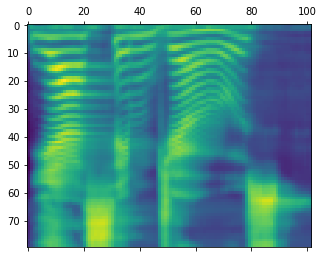

In [ ]:
import matplotlib.pyplot as plt
import kaldiio
fbank = next(iter(kaldiio.load_scp("decode/translated_sed/outputs/feats.scp").values()))
plt.matshow(fbank.T)

In [ ]:
from IPython.display import display, Audio
display(Audio("decode/translated_sed/wav_wnv/translated_sed_gen.wav"))

Successfully, it says "Yes I'm Jose"! For more TTS demo, visit https://colab.research.google.com/github/espnet/notebook/blob/master/tts_realtime_demo.ipynb

## Check decoding log

After the translation, you will find `<decode_dir>/<wav name>/result.json` for details;

In [ ]:
!cat decode/st_test/result.json

{
    "utts": {
        "st_test": {
            "output": [
                {
                    "name": "target1[1]",
                    "rec_text": "▁yes▁i▁&apos;m▁jose<eos>",
                    "rec_token": "▁yes ▁i ▁ &apos; m ▁j ose <eos>",
                    "rec_tokenid": "991 638 371 2 219 656 256 999",
                    "score": 1.0691701889038088,
                    "shape": [
                        1,
                        3
                    ],
                    "text": "X",
                    "token": "X",
                    "tokenid": "1"
                }
            ],
            "utt2spk": "X"
        }
    }
}

and `<decode_dir>/<wav name>/log/decode.log` for runtime log;

In [ ]:
!cat decode/st_test/log/decode.log

# st_trans.py --config decode/download/fisher_callhome_spanish.transformer.v1.es-en/conf/tuning/decode_pytorch_transformer_bpe.yaml --ngpu 0 --backend pytorch --debugmode 1 --verbose 1 --trans-json decode/st_test/dump/data.json --result-label decode/st_test/result.json --model decode/download/fisher_callhome_spanish.transformer.v1.es-en/exp/train_sp.en_lc.rm_pytorch_train_pytorch_transformer_bpe_short_long_bpe1000_specaug_asrtrans_mttrans/results/model.val5.avg.best --api v2 
# Started at Sat Feb  1 06:27:34 UTC 2020
#
2020-02-01 06:27:34,638 (st_trans:126) INFO: python path = /env/python
2020-02-01 06:27:34,640 (st_trans:131) INFO: set random seed = 1
2020-02-01 06:27:34,640 (st_trans:139) INFO: backend = pytorch
2020-02-01 06:27:40,269 (deterministic_utils:24) INFO: torch type check is disabled
2020-02-01 06:27:40,269 (asr_utils:439) INFO: reading a config file from decode/download/fisher_callhome_spanish.transformer.v1.es-en/exp/train_sp.en_lc.rm_pytorch_train_pytorch_transformer_bp

Let's calculate real-time factor (RTF) of the ST decoding from the `decode.log`

In [ ]:
from dateutil import parser
from subprocess import PIPE, run

# calc input duration (seconds)
input_sec = float(run(["soxi", "-D", "/content/espnet/test_utils/st_test.wav"], stdout=PIPE).stdout)

# calc NN decoding time
with open("decode/st_test/log/decode.log", "r") as f:
  times = [parser.parse(x.split("(")[0]) for x in f if "e2e_st_transformer" in x]
decode_sec = (times[-1] - times[0]).total_seconds()

# get real-time factor (RTF)
print("Input duration:\t", input_sec, "sec")
print("NN decoding:\t", decode_sec, "sec")
print("Real-time factor:\t", decode_sec / input_sec)

Input duration:	 2.0 sec
NN decoding:	 1.551 sec
Real-time factor:	 0.7755


As you can see above, ESPnet-ST can **translate speech faster than the input** (it should be RTF < 1.0).

## Training ST models from scratch

We provide [Kaldi-style recipes](https://kaldi-asr.org/doc/kaldi_for_dummies.html) for ST as well as [ASR](https://colab.research.google.com/github/espnet/notebook/blob/master/asr_cli.ipynb) and [TTS](https://colab.research.google.com/github/espnet/notebook/blob/master/tts_cli.ipynb) as all-in-one bash script `run.sh`:

In [ ]:
!cd /content/espnet/egs/must_c/st1/ && ./run.sh --must-c /content

stage -1: Data Download
local/download_and_untar.sh: downloading data from https://drive.google.com/open?id=1Mf2il_VelDIJMSio0bq7I8M9fSs-X4Ie.  This may take some time, please be patient.
--2020-01-31 06:29:10--  https://drive.google.com/uc?export=download&id=1Mf2il_VelDIJMSio0bq7I8M9fSs-X4Ie
Resolving drive.google.com (drive.google.com)... 172.217.214.102, 172.217.214.138, 172.217.214.100, ...
Connecting to drive.google.com (drive.google.com)|172.217.214.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: '/content/WGgpBx.tar.gz'

/content/WGgpBx.tar     [ <=>                ]   3.18K  --.-KB/s    in 0s      

2020-01-31 06:29:11 (38.8 MB/s) - '/content/WGgpBx.tar.gz' saved [3259]


gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent

However, it takes too much time to finish downloading the dataset. So we cancel the cell above.

## Details of ESPnet tools

In [ ]:
!../../../utils/translate_wav.sh --help

Usage:
    ../../../utils/translate_wav.sh [options] <wav_file>

Options:
    --ngpu <ngpu>                   # Number of GPUs (Default: 0)
    --decode_dir <directory_name>   # Name of directory to store decoding temporary data
    --models <model_name>           # Model name (e.g. tedlium2.transformer.v1)
    --cmvn <path>                   # Location of cmvn.ark
    --trans_model <path>            # Location of E2E model
    --decode_config <path>          # Location of configuration file
    --api <api_version>             # API version (v1 or v2)

Example:
    # Record audio from microphone input as example.wav
    rec -c 1 -r 16000 example.wav trim 0 5

    # Decode using model name
    ../../../utils/translate_wav.sh --models must_c.transformer.v1.en-fr example.wav

    # Decode using model file
    ../../../utils/translate_wav.sh --cmvn cmvn.ark --trans_model model.acc.best --decode_config conf/decode.yaml example.wav

    # Decode with GPU (require batchsize > 0 in configurati

In [ ]:
!../../../utils/synth_wav.sh --help

Usage:
    $ ../../../utils/synth_wav.sh <text>

Example:
    # make text file and then generate it
    echo "This is a demonstration of text to speech." > example.txt
    ../../../utils/synth_wav.sh example.txt

    # you can specify the pretrained models
    ../../../utils/synth_wav.sh --models ljspeech.transformer.v3 example.txt

    # also you can specify vocoder model
    ../../../utils/synth_wav.sh --vocoder_models ljspeech.wavenet.mol.v2 --stop_stage 4 example.txt

Available models:
    - ljspeech.tacotron2.v1
    - ljspeech.tacotron2.v2
    - ljspeech.tacotron2.v3
    - ljspeech.transformer.v1
    - ljspeech.transformer.v2
    - ljspeech.transformer.v3
    - ljspeech.fastspeech.v1
    - ljspeech.fastspeech.v2
    - ljspeech.fastspeech.v3
    - libritts.tacotron2.v1
    - libritts.transformer.v1
    - jsut.transformer.v1
    - jsut.tacotron2.v1
    - csmsc.transformer.v1
    - csmsc.fastspeech.v3

Available vocoder models:
    - ljspeech.wavenet.softmax.ns.v1
    - ljspeech.wave